In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = yf.download(tickers, start='2020-01-01', end='2024-12-31')['Close']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [3]:
returns = data.pct_change().dropna()
mean_return = returns.mean()
cov_return = returns.cov()

In [4]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns) * 252  # annualized
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # annualized
    return returns, std_dev

In [5]:
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    ret, std_dev = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (ret - risk_free_rate) / std_dev
    return -sharpe

In [6]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))


In [9]:
initial_guess = [1/len(tickers)] * len(tickers)
opt_result = minimize(negative_sharpe, initial_guess, args=(mean_return, cov_return),
                      method='SLSQP', bounds=bounds, constraints=constraints)


In [10]:
opt_weights = opt_result.x
opt_ret, opt_vol = portfolio_performance(opt_weights, mean_return, cov_return)
sharpe_ratio = (opt_ret - 0.01) / opt_vol


In [15]:
def simulate_portfolios(num_portfolios):
    results = {'returns': [], 'volatility': [], 'sharpe': [], 'weights': []}
    for _ in range(num_portfolios):
        weights = np.random.dirichlet(np.ones(len(tickers)), size=1)[0]
        ret, vol = portfolio_performance(weights, mean_return, cov_return)
        sharpe = (ret - 0.01) / vol
        results['returns'].append(ret)
        results['volatility'].append(vol)
        results['sharpe'].append(sharpe)
        results['weights'].append(weights)
    return pd.DataFrame(results)


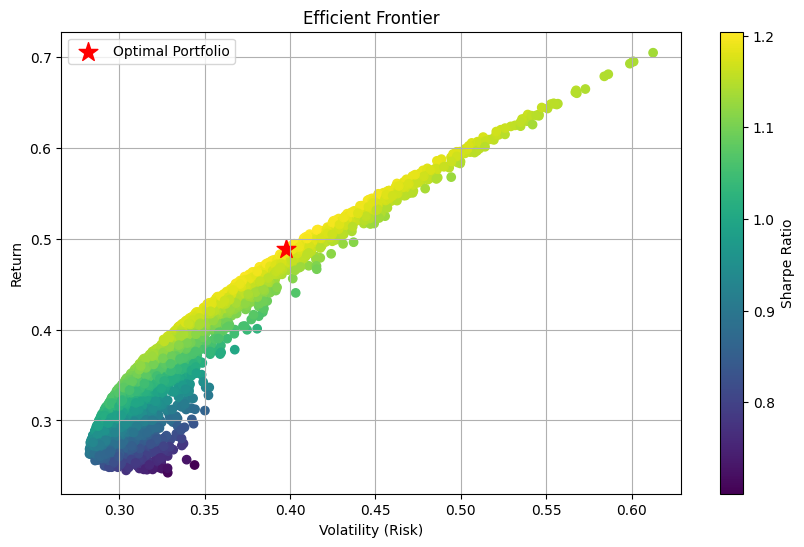

In [16]:
portfolios = simulate_portfolios(5000)

plt.figure(figsize=(10, 6))
plt.scatter(portfolios['volatility'], portfolios['returns'], c=portfolios['sharpe'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_vol, opt_ret, color='red', marker='*', s=200, label='Optimal Portfolio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()
